## Estilização da Saída do Markdown (VSCODE)

In [41]:
%%HTML
<style>
  body {
    --vscode-font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>

# Simulador de uma Microrrede DC como CPL (Carga de Potência Constante)

## Descrição

Este notebook apresenta a implementação da modelagem matemática e do controlador de uma microrrede de corrente contínua, representada por um conversor buck com uma CPL (Carga de Potência Constante). O conversor buck é um dispositivo de conversão de potência que transforma uma tensão contínua de alta para baixa. A CPL é uma carga que demanda potência constante, independentemente da variação na tensão de entrada.

Para a implementação, serão utilizadas as bibliotecas Python Control, NumPy e Matplotlib. A modelagem matemática detalhada pode ser encontrada no documento separado chamado ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), localizado no diretório `docs`. Durante a implementação, serão explorados o sistema não linear, o sistema não linear transladado e o sistema linearizado, todos derivados da modelagem matemática.

### Data de Criação

2023-12-21

### Data de Modificação

2024-01-31

## Autor

Andevaldo da Encarnação Vitório

## Importação de Bibliotecas
- OS
- Matplot
- Python Control Systems

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
ct.use_fbs_defaults()

## Descrição do Sistema e Circuito

O sistema a seguir foi projetado para simplificar a representação de uma microrrede, visando facilitar cálculos e análises. Composto por um conversor buck e uma CPL configurada como carga de potência constante, representada por uma fonte de corrente, o sistema oferece uma abordagem eficiente para modelar o comportamento da microrrede.

<p align="center">
  <img src="../assets/imgs/buck_conversor_with_cpl_circuit.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

No circuito apresentado:

- $R_L, \space R_C, \space C, \space L$: Resistores, capacitor e indutor do circuito.
- $d$: Duty Cycle
- $I_{CPL}$: Corrente da CPL
- $V_{in}$: Tensão de entrada.
- $V_{out}$: Tensão de entrada.

Neste circuito, $I_{CPL}$ depende da tensão do capacitor $v_C$ e da potência da CPL:

$$ I_{CPL} = \frac{P_{CPL}}{v_C}$$

## Modelo Não-linear do Sistema
O modelo matemático adotado para o conversor buck baseia-se no modelo médio do sistema. Embora os conversores sejam naturalmente não-lineares, é comum empregar modelos de pequenos sinais (SSMs) para linearizar a representação em torno do ponto operacional (OP), considerando as situações de chave fechada e aberta.

### Chave Fechada

Nesta configuração, a chave do conversor está fechada. O circuito é equivalente a um circuito série com uma fonte de tensão, um resistor e uma indutância. Durante este estado, as equações descrevem a variação da corrente $i_L$ no indutor e a tensão $v_C$ no capacitor.

<p align="center">
  <img src="../assets/imgs/buck_conversor_with_cpl_circuit_m1.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

O modelo para a chave fechada é:

<br>

$$
\begin{equation}
  \tag{1.1} 
  M_{F}: \space
  \begin{cases}
    \frac{d}{dt}i_L &= \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
    \frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
  \end{cases}
\end{equation}
$$

<br>

### Chave Aberta

Na situação em que a chave está aberta, o circuito é desconectado da fonte de tensão.

<p align="center">
  <img src="../assets/imgs/buck_conversor_with_cpl_circuit_m2.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

O modelo para a chave aberta é:

$$
\begin{equation}
  M_{A}: \space
  \tag{1.2} 
  \begin{cases}
    \frac{d}{dt}i_L &= \frac{V_{in}}{L} d - \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
    \frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
  \end{cases}
\end{equation}
$$

### Modelo Médio do Sistema

Baseado nas equações anteriores, o modelo médio do sistema é representado pelas equações diferenciais abaixo:

<br>

$$
\begin{equation}
MMS: \space
\tag{2} 
\begin{cases}
\frac{d}{dt}i_L &= \frac{V_{in}}{L} d - \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
\frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
\end{cases}
\end{equation}
$$

<br>


## Implementação do Modelo Não-linear

### Definição de Funções de Atualização e Saída

Definição de uma função de atualização (para o lado direito da equação diferencial) e de uma função de saída (calcula as saídas a partir do estado)


In [14]:
def update_nonlinear(t, x, u, params):
  """
  Atualiza o sistema dinâmico não linear.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - dx: derivadas dos estados
  """
  # Definição dos parâmetros do sistema
  Vin = params.get('Vin')   # Tensão de Entrada
  Rl = params.get('rl')     # Resistência (indutor)
  Rc = params.get('rc')     # Resistência (capacitor)
  L = params.get('L')       # Indutância
  C = params.get('C')       # Capacitância

  # Definição das entradas do sistema
  d, Pcpl = u[0], u[1]      # Duty Cycle e Potência da CPL, respectivamente

  # Definição dos estados do sistema
  # Corrente do indutor e tensão do capacitor, respectivamente
  Il, Vc = x[0], x[1]

  # Atualização
  dIl = (Vin / L) * d - (Rl / L) * Il - Vc / L      # Corrente do indutor
  dVc = Il / C - Vc / (C * Rc) - Pcpl / (C * Vc)    # Tensão do capacitor

  dx = np.array([dIl, dVc])

  return dx


def system_output(t, x, u, params):
  """
  Calcula a saída do sistema.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - y: saída do sistema
  """
  return x[0:2]


# Definição do sistema não-linear
sys_nonlinear = ct.NonlinearIOSystem(
    update_nonlinear, system_output,
    name='sys_nonlinear',
    inputs=('d', 'Pcpl'), 
    outputs=('i_L', 'v_C'), 
    states=('i_L', 'v_C')
)

### Definição dos Parâmetros da Simulação

 Especificação e atribuição dos valores iniciais aos parâmetros necessários para realizar a simulação do sistema não-linear.

In [20]:
# Parâmetros do Circuito
params = {'Vin': 48, 'rl': 0.1, 'rc': 10,
          'L': 40e-3, 'C': 10e-6, 'op': {'Pcpl': 15, 'VC': 24}}

# Tempo de Simulação
ti = 0
tf = 0.03
npts = 1000000

timepts = np.linspace(ti, tf, npts)

# Cálculo da Corrente e Duty Cycle de Operação
op = params['op']
IL_OP = (op['VC'] / params['rc']) + op['Pcpl'] / op['VC']
D_OP = (params['rl'] * IL_OP) / params['Vin'] + op['VC'] / params['Vin']

params['op']['IL'] = IL_OP
params['op']['D'] = D_OP

params

{'Vin': 48,
 'rl': 0.1,
 'rc': 10,
 'L': 0.04,
 'C': 1e-05,
 'op': {'Pcpl': 15, 'VC': 24, 'IL': 3.025, 'D': 0.5063020833333334}}

### Resposta do Sistema Não Linear

In [24]:
# Entradas do Sistema
D = params['op']['D']
P_CPL= params['op']['Pcpl']
U = [D, P_CPL]
U_OP = [params['op']['D'], params['op']['Pcpl']]

# Estados Iniciais do Sistema
IL_INIT = 0.95 * params['op']['IL']
VC_INIT = 1.05 * params['op']['VC']
X0 = [IL_INIT, VC_INIT]
X_OP = [params['op']['VC'], params['op']['IL']]

# Obtenção da saída
t, y_nonlinear = ct.input_output_response(sys=sys_nonlinear, T=timepts, U=U, X0=X0, params=params)

### Apresentação dos Resultados

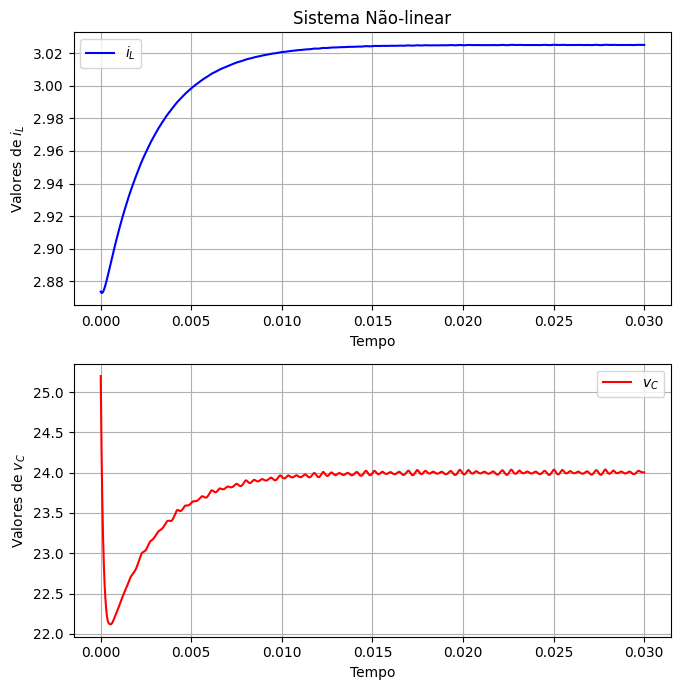

In [43]:
plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.plot(t, y_nonlinear[0], linestyle='-', color='b', label='$i_L$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $i_L$')
plt.title('Sistema Não-linear')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, y_nonlinear[1], linestyle='-', color='r', label='$v_C$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $v_C$')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

## Linearização do Sitema

A seguir é apresentado os parâmetros para a linearização do sistema:

### Tabela de estados, entradas, parâmetros, ponto de operação e saída

| **Categoria**         | **Nome**                             | **Definição**                                  |
| --------------------- | ------------------------------------ | ---------------------------------------------- |
| **Estados**           | Variação da corrente do indutor      | $\delta i_L(t) = i_L(t) - {i_L}_0$             |
|                       | Variação da tensão do capacitor      | $\delta v_C(t) = v_C(t) - {v_C}_0$             |
| **Entradas**          | Variação do duty cycle               | $\delta d(t) = d(t) - d_0$                     |
|                       | Variação da potência da carga        | $\delta P_{cpl}(t) = P_{cpl}(t) - {P_{cpl}}_0$ |
| **Parâmetros**        | Tensão de entrada                    | $V_{in}$                                       |
|                       | Resistência em série com o indutor   | $R_L$                                          |
|                       | Resistência em paralelo ao capacitor | $R_c$                                          |
|                       | Indutância                           | $L$                                            |
|                       | Capacitância                         | $C$                                            |
| **Ponto de operação** | Corrente do indutor                  | ${i_L}_0$                                      |
|                       | Tensão do capacitor                  | ${v_C}_0$                                      |
|                       | Duty cycle                           | ${d}_0$                                        |
|                       | Potência da carga                    | ${P_{cpl}}_0$                                  |
| **Saída**             | Variação da Tensão do Capacitor      | $y = \delta v_C$                               |

O sistema linearizado terá a forma:

$$
  \begin{cases}
    \frac{d}{dt} (\delta i_L) &= k_1 \cdot \delta i_L + k_2 \cdot \delta v_C + k_3 \cdot \delta d \\ \\
    \frac{d}{dt} (\delta v_C) &= k_4 \cdot \delta i_L + k_5 \cdot \delta v_C + k_6 \cdot \delta P_{CPL}
  \end{cases}
$$

Considerando as seguinte relações:

$$P_f = (i_L, v_C, d), \space\space {P_f}_0 = ({i_L}_0, {v_C}_0, d_0)$$  
$$P_g = (i_L, v_C, P_{CPL}), \space\space   {P_g}_0 = ({i_L}_0, {v_C}_0, {P_{CPL}}_0)$$  
$$f(P_f) = \frac{d}{dt}i_L, \space\space  g(P_g) = \frac{d}{dt}v_C$$

Podemos obter as constante:

$$
k_1 = \dfrac{\partial f}{\partial i_L} \vert _{P_f = {P_f}_0}, \space \space
k_2 = \dfrac{\partial f}{\partial v_C} \vert _{P_f = {P_f}_0}, \space \space
k_3 = \dfrac{\partial f}{\partial d} \vert _{P_f = {P_f}_0}
$$

$$
k_4 = \dfrac{\partial g}{\partial i_L} \vert _{P_g = {P_g}_0}, \space \space
k_5 = \dfrac{\partial g}{\partial v_C} \vert _{P_g = {P_g}_0}, \space \space
k_6 = \dfrac{\partial g}{\partial P_{CPL}} \vert _{P_g = {P_g}_0}
$$

Desta forma, os termos são:

$$
k_1 = - \frac{R_L}{L}, \space\space
k_2 = - \frac{1}{L}, \space\space
k_3 = \frac{V_{in}}{L}
$$

$$
k_4 = \frac{1}{C}, \space\space
k_5 = \frac{1}{C}\left(\frac{{P_{CPL}}_0}{{{{v_{C}}_0}^2}} - \frac{1}{R_C}\right), \space\space
k_6 = - \frac{1}{C {v_C}_0}
$$

Portanto, o sistema linearizado é:

$$
  \begin{cases}
    \frac{d}{dt} (\delta i_L) &= - \frac{R_L}{L} \delta i_L - \frac{1}{L} \delta v_C + \frac{V_{in}}{L} \delta d \\ \\
    \frac{d}{dt} (\delta v_C) &= \frac{1}{C} \delta i_L + \frac{1}{C}\left(\frac{{P_{CPL}}_0}{{{{v_{C}}_0}^2}} - \frac{1}{R_C}\right) \delta v_C - \frac{1}{C {v_C}_0} \delta P_{CPL}
  \end{cases}
$$


In [40]:
# definição das constantes
k1 = - (rl / L)
k2 = - (1.0 / L)
k3 = Vin / L
k4 = 1.0 / C
k5 = (1.0 / C) * (_Pcpl / (_Vc * _Vc) - 1.0 / rc)
k6 = - 1.0 / (C * _Vc )

_A = [[k1, k2], [k4, k5]]
_B = [[k3, 0], [0, k6]]
_C = [[1., 0],[0., 1]]
_D = [[0,0],[0,0]]

sys_linear = ss(_A, _B, _C, _D)

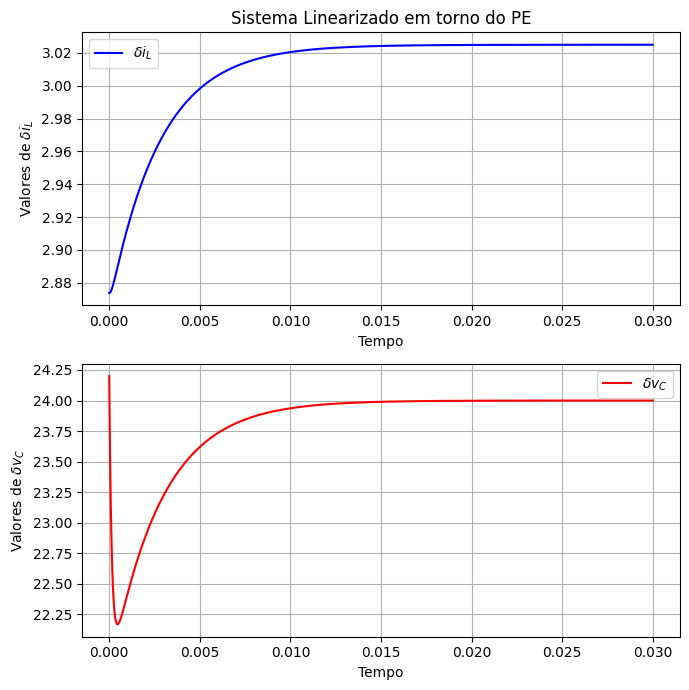

In [46]:
sys_linear_io = ct.ss2io(sys_linear, inputs=2, outputs=2, states=2)

t, y_linear = ct.input_output_response(sys=sys_linear_io, T=timepts, U= [U[0] - _u[0], U[1] - _u[1]], X0=[X0[0] - _x[0],X0[1] - _x[1],])

# Configuração do primeiro subplot (i_L)
plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.plot(t, y_linear[0] + _iL, linestyle='-', color='b', label='$\delta i_L$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $\delta i_L$')
plt.title('Sistema Linearizado em torno do PE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, y_linear[1] + _Vc, linestyle='-', color='r', label='$ \delta v_C$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $\delta v_C$')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

## Modelo do Sistema não linear em Torno do PE

Temos que

1. $P_E = \left( \overline{i_L}, \, \overline{V_C}, \, \overline{d}, \, \overline{P_{CPL}} \right)$

2.
$$
\begin{cases}
  i_L &= \overline{i_L} + \delta i_L \\
  v_C &= \overline{V_C} + \delta V_C \\
  d &= \overline{d} + \delta d \\
  P_{CPL} &= \overline{P_{CPL}} + \delta P_{CPL} \\
\end{cases}
$$
 
3.
$$
\begin{cases}
  \dot{i_L} &= \overline{\dot{i_L}} + \delta \dot{i_L} \\
  \dot{v_C} &= \overline{\dot{v_C}} + \delta \dot{v_C} \\
\end{cases}
$$

Além disto, 

$$ f(i_L, \, v_C, \, d, \, P_{CPL}) = \dot{i_L} = - \frac{R_L}{L} i_L - \frac{1}{L} v_C + \frac{V_{in}}{L} d $$
$$ g(i_L, \, v_C, \, d, \, P_{CPL}) = \dot{v_C}= - \frac{1}{C R_C} v_C + \frac{1}{C} i_L - \frac{1}{C v_C} P_{CPL} $$

$$ f(P_E) = g(P_E) = \overline{\dot{i_L}} = \overline{\dot{v_C}} = 0 $$

### Equação da Corrente $i_L$
Temos, 

$$
f(P_E) = - \frac{R_L}{L} \overline{i_L} - \frac{1}{L} \overline{v_C} + \frac{V_{in}}{L}  \overline{d} = 0
$$

$$ - R_L \overline{i_L} - \overline{v_C} + V_{in}  \overline{d} = 0 $$

$$ V_{in}  \overline{d} = R_L \overline{i_L} + \overline{v_C} $$

$$ \overline{d} = \frac{R_L}{V_{in}} \overline{i_L} + \frac{\overline{v_C}}{V_{in}} $$


Baseado nisto, podemos simplificar a equação $\dot{i_L}$ em,

$$ \dot{i_L} = - \frac{R_L}{L} i_L - \frac{1}{L} v_C + \frac{V_{in}}{L} d $$

$$ \overline{\dot{i_L}} + \delta \dot{i_L} = - \frac{R_L}{L} \left(\overline{i_L} + \delta i_L\right) - \frac{1}{L} \left(\overline{v_C} + \delta v_C\right) + \frac{V_{in}}{L} \left(\overline{d} + \delta d\right) $$

$$ \delta \dot{i_L} = - \frac{R_L}{L} \overline{i_L} - \frac{R_L}{L} \delta i_L - \frac{1}{L} \overline{v_C} - \frac{1}{L} \delta v_C + \frac{V_{in}}{L} \overline{d} + \frac{V_{in}}{L} \delta d $$

$$ \delta \dot{i_L} = - \frac{R_L}{L} \overline{i_L} - \frac{R_L}{L} \delta i_L - \frac{1}{L} \overline{v_C} - \frac{1}{L} \delta v_C + \frac{V_{in}}{L} \left( \frac{R_L}{V_{in}} \overline{i_L} + \frac{\overline{v_C}}{V_{in}}\right) + \frac{V_{in}}{L} \delta d $$

$$ \delta \dot{i_L} = - \frac{R_L}{L} \overline{i_L} - \frac{R_L}{L} \delta i_L - \frac{1}{L} \overline{v_C} - \frac{1}{L} \delta v_C +  \frac{R_L}{L} \overline{i_L} + \frac{1}{L} \overline{v_C} + \frac{V_{in}}{L} \delta d $$

$$ \delta \dot{i_L} = - \frac{R_L}{L} \delta i_L - \frac{1}{L} \delta v_C  + \frac{V_{in}}{L} \delta d $$

### Equação da Tensão $v_C$

Temos, 

$$ g(P_E) = - \frac{1}{C R_C} \overline{v_C} + \frac{1}{C} \overline{i_L} - \frac{1}{C \overline{v_C}} \overline{P_{CPL}} = 0 $$

$$ - \frac{1}{R_C} \overline{v_C} + \overline{i_L} - \frac{1}{\overline{v_C}} \overline{P_{CPL}} = 0 $$

$$  \overline{i_L} = \frac{1}{R_C} \overline{v_C} + \frac{1}{\overline{v_C}} \overline{P_{CPL}} $$


Baseado nisto, podemos simplificar a equação $\dot{v_C}$ em,

$$ 
\dot v_C = - \frac{1}{C R_C} v_C + \frac{1}{C} i_L - \frac{1}{C v_C} P_{CPL} 
$$

$$ 
\overline{\dot{v_C}} + \delta \dot{v_C} = - \frac{1}{C R_C} \left(\overline{v_C} + \delta v_C\right) + \frac{1}{C} \left( \overline{i_L} + \delta i_L\right) - \frac{1}{C \left(\overline{v_C} + \delta v_C\right)} \left(\overline{P_{CPL}} + \delta P_{CPL}\right) 
$$

$$ 
\delta \dot{v_C} = - \frac{1}{C R_C} \overline{v_C} - \frac{1}{C R_C} \delta v_C + \frac{1}{C} \overline{i_L} + \frac{1}{C}  \delta i_L - \frac{1}{C \left(\overline{v_C} + \delta v_C\right)} \left(\overline{P_{CPL}} + \delta P_{CPL}\right) 
$$

$$ 
\delta \dot{v_C} = - \frac{1}{C R_C} \overline{v_C} - \frac{1}{C R_C} \delta v_C + \frac{1}{C} \left(\frac{1}{R_C} \overline{v_C} + \frac{1}{\overline{v_C}} \overline{P_{CPL}}\right) + \frac{1}{C}  \delta i_L - \frac{1}{C \left(\overline{v_C} + \delta v_C\right)} \left(\overline{P_{CPL}} + \delta P_{CPL}\right) 
$$

$$ 
\delta \dot{v_C} = - \frac{1}{C R_C} \delta v_C + \frac{1}{C \overline{v_C}} \overline{P_{CPL}} + \frac{1}{C}  \delta i_L - \frac{1}{C \left(\overline{v_C} + \delta v_C\right)} \left(\overline{P_{CPL}} + \delta P_{CPL}\right) 
$$

$$ 
\delta \dot{v_C} = - \frac{1}{C R_C} \delta v_C  + \frac{1}{C}  \delta i_L + \frac{\overline{P_{CPL}} \delta v_C - \overline{v_C} \delta P_{CPL}}{C \overline{v_C} \left(\overline{v_C} + \delta v_C\right)} 
$$


In [43]:
def update_nonlinear_pe(t, x, u, params):

  # Definição dos parâmetros do sistema
  Vin = params.get('Vin')
  Rl = params.get('rl')
  Rc = params.get('rc')
  L = params.get('L')
  C = params.get('C')

  _Pcpl = params.get('_Pcpl')
  _Vc = params.get('_Vc')

  #Definição das entradas do sistema
  d = u[0]
  Pcpl = u[1]

  # Definição dos estados do sistema
  Il = x[0]
  Vc = x[1]
    
  # Atualização
  dIl = (Vin / L) * d - (Rl / L) * Il - Vc / L
  dVc = Il / C - Vc / (C * Rc) + (_Pcpl * Vc - _Vc * Pcpl) / (C * _Vc * (_Vc + Vc))
  
  dx = np.array([dIl, dVc])
  
  return dx

sys_nonlinear_pe = ct.NonlinearIOSystem(
  update_nonlinear_pe, system_output, 
  inputs=2, outputs=2, states=2
)

t, y_nonlinear_pe = ct.input_output_response(sys=sys_nonlinear_pe, T=timepts, U= [U[0] - _u[0], U[1] - _u[1]], X0=[X0[0] - _x[0],X0[1] - _x[1],], params=params)

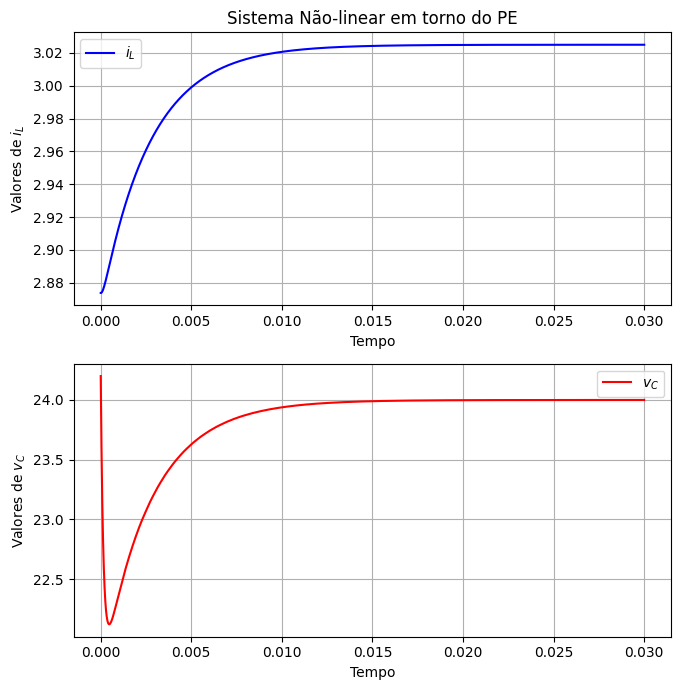

In [44]:
# Configuração do primeiro subplot (i_L)
plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.plot(t, y_nonlinear_pe[0] + _iL, linestyle='-', color='b', label='$i_L$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $i_L$')
plt.title('Sistema Não-linear em torno do PE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, y_nonlinear_pe[1] + _Vc, linestyle='-', color='r', label='$v_C$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $v_C$')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

## Gráficos

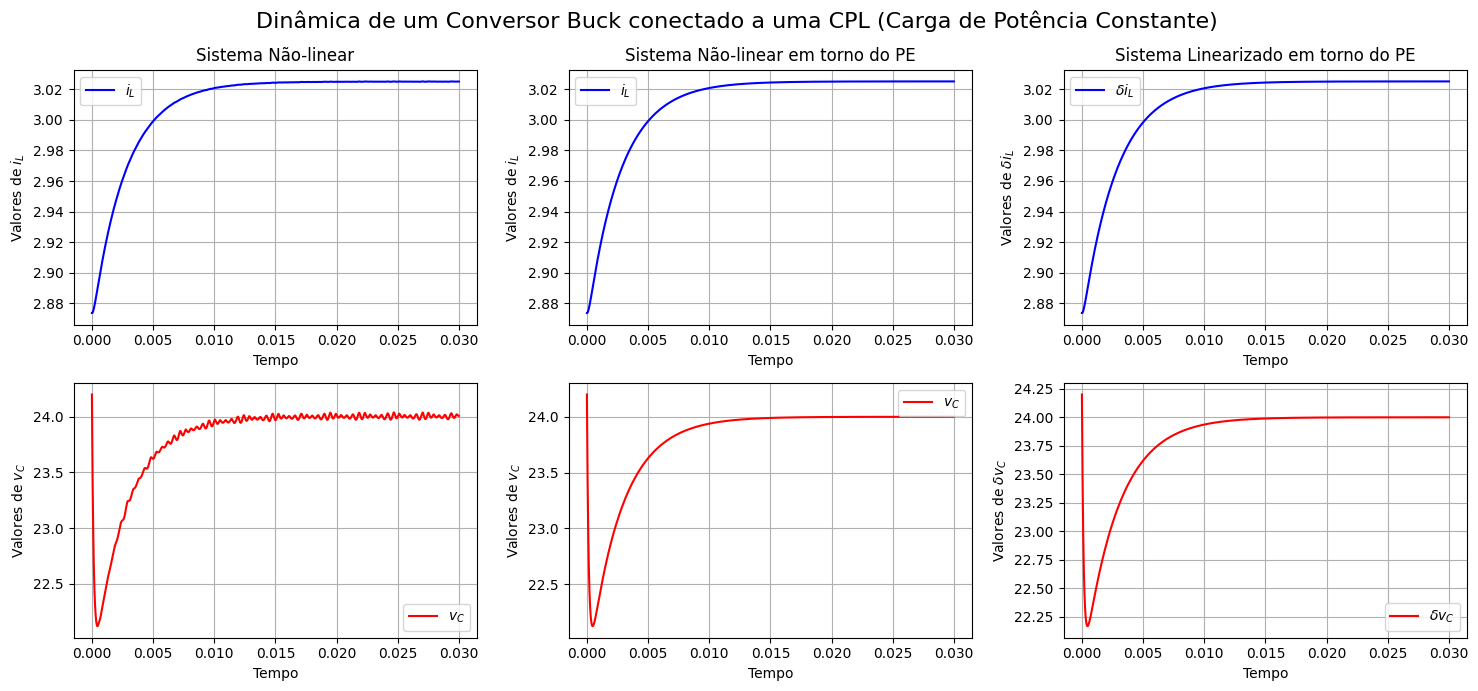

In [48]:
plt.figure(figsize=(15, 7))

# Subplot 1
plt.subplot(2, 3, 1)
plt.plot(t, y_nonlinear[0], linestyle='-', color='b', label='$i_L$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $i_L$')
plt.title('Sistema Não-linear')
plt.legend()
plt.grid(True)

# Subplot 2
plt.subplot(2, 3, 4)
plt.plot(t, y_nonlinear[1], linestyle='-', color='r', label='$v_C$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $v_C$')
plt.legend()
plt.grid(True)

# Subplot 3
plt.subplot(2, 3, 2)
plt.plot(t, y_nonlinear_pe[0] + _iL, linestyle='-', color='b', label='$i_L$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $i_L$')
plt.title('Sistema Não-linear em torno do PE')
plt.legend()
plt.grid(True)

# Subplot 4
plt.subplot(2, 3, 5)
plt.plot(t, y_nonlinear_pe[1] + _Vc, linestyle='-', color='r', label='$v_C$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $v_C$')
plt.legend()
plt.grid(True)

# Subplot 5
plt.subplot(2, 3, 3)
plt.plot(t, y_linear[0] + _iL, linestyle='-', color='b', label='$\delta i_L$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $\delta i_L$')
plt.title('Sistema Linearizado em torno do PE')
plt.legend()
plt.grid(True)

# Subplot 6
plt.subplot(2, 3, 6)
plt.plot(t, y_linear[1] + _Vc, linestyle='-', color='r', label='$\delta v_C$')
plt.xlabel('Tempo')
plt.ylabel('Valores de $\delta v_C$')
plt.legend()
plt.grid(True)

plt.suptitle('Dinâmica de um Conversor Buck conectado a uma CPL (Carga de Potência Constante)', fontsize=16)

plt.tight_layout()
plt.show()
